In [5]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET = 'NONE'

In [8]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../../../hardware/victims/firmware/basic-passwdcheck
make PLATFORM=$1 CRYPTO_TARGET=$2

SS_VER set to SS_VER_1_0
rm -f -- basic-passwdcheck-CWLITEARM.hex
rm -f -- basic-passwdcheck-CWLITEARM.eep
rm -f -- basic-passwdcheck-CWLITEARM.cof
rm -f -- basic-passwdcheck-CWLITEARM.elf
rm -f -- basic-passwdcheck-CWLITEARM.map
rm -f -- basic-passwdcheck-CWLITEARM.sym
rm -f -- basic-passwdcheck-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- basic-passwdcheck.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- basic-passwdcheck.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- basic-passwdcheck.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:6.3.1+svn253039-1build1) 6.3.1 20170620
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: basic-passwdch

.././simpleserial/simpleserial.c: In function 'simpleserial_get':
.././simpleserial/simpleserial.c:131:10: warning: variable 'ret' set but not used [-Wunused-but-set-variable]
  uint8_t ret[1];
          ^~~


In [12]:
%run "../../../../jupyter/Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [15]:
fw_path = '../../../../hardware/victims/firmware/basic-passwdcheck/basic-passwdcheck-{}.hex'.format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5759 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5759 bytes
Serial baud rate = 38400


In [53]:
import time

scope.adc.samples = 3000

def reset_target(scope):
    if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        scope.io.pdic = 'low'
        time.sleep(0.05)
        scope.io.pdic = 'high'
        time.sleep(0.05)
    else:  
        scope.io.nrst = 'low'
        time.sleep(0.005)
        scope.io.nrst = 'high'
        time.sleep(0.005)

In [54]:
def cap_pass_trace(pass_guess):
    ret = ""
    reset_target(scope)
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(num_char, 10)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

<IPython.core.display.Javascript object>


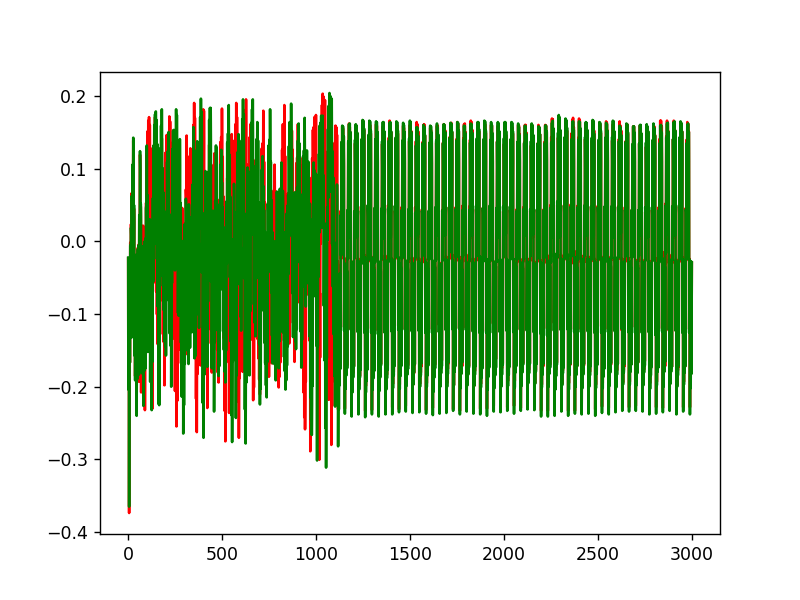

In [55]:
%matplotlib notebook
import matplotlib.pylab as plt

trace_correct = cap_pass_trace("h0\n")
trace_wrong   = cap_pass_trace("h9\n")

     
plt.plot(trace_wrong, 'r')
plt.plot(trace_correct, 'g')

In [81]:
import itertools
from tqdm.notebook import tqdm_notebook
import numpy as np
import pickle

trylist = "abcdefghijklmnopqrstuvwxyz0123456789"
pw = ""

def do_the_thang(pw):
    print(pw)

traces = {}
    
known_passwd = "h0px3"
    
#Capture N of each
N_each = 100

traces["N_each"] = N_each

for j in range(1,6):
    #j = capture length
    #Get totally wrong option
    guesslist = [" "*j]
        
    for k in range(1, j):
        guess = known_passwd[0:k] + " "*(j-k)
        guesslist.append(guess)
        
    guesslist.append(known_passwd[0:j])
    print(guesslist)
    
    #Get fully correct
    for guess in tqdm_notebook(guesslist):
        traces[guess] = [0] * N_each
        for i in range(0, N_each):
            traces[guess][i] = cap_pass_trace(guess + "\n")
        
        
pickle.dump(traces, open("../traces/lab2_1b_passwords_full.p", "wb"))


[' ', 'h']


['  ', 'h ', 'h0']


['   ', 'h  ', 'h0 ', 'h0p']


['    ', 'h   ', 'h0  ', 'h0p ', 'h0px']


['     ', 'h    ', 'h0   ', 'h0p  ', 'h0px ', 'h0px3']
